## Shape-based Evaluation of Epidemic Forecasts Example




## Definitions

Shapelet : Shapelets are defined as “subsequences that are in some sense maximally representative of a class”. Informally, if we assume a binary classification setting, a shapelet is discriminant if it is present in most series of one class and absent from series of the other class.<br>

In this work, we have used 6 shapelets which depict various stages in a pandemic wave

__Flat__: [1, 1, 1, 1, 1] <br>
__Stable-inc__: [1 ,2, 3, 4, 5], i.e., linear<br>
__Stable-dec__: [5, 4, 3, 2, 1], i.e., linear but decreasing<br>
__Surge__: [exp(-1/2) ,exp(0/2), exp(1/2), exp(2/2), exp(3/2)], i.e., like exp(x)<br>
__Peaking__: - [exp(1/2) ,exp(0/2) ,exp(-1/2) ,exp(-2/2), exp(-3/2)], i.e., like -exp(-x)<br>
__At/near peak__:  - [exp(-1/2), exp(0/2), exp(1/2), exp(2/2), exp(3/2)], i.e., like -exp(x)


### Pearson Correlation:

<img src="https://editor.analyticsvidhya.com/uploads/39170Formula.JPG" width="400" height="500">

### Cosine Similarity
cosine similarity for comparing the two vectors, which is defined as follows:
\begin{equation}
\cos ({\bf t},{\bf e})= {{\bf t} {\bf e} \over \|{\bf t}\| \|{\bf e}\|} = \frac{ \sum_{i=1}^{n}{{\bf t}_i{\bf e}_i} }{ \sqrt{\sum_{i=1}^{n}{({\bf t}_i)^2}} \sqrt{\sum_{i=1}^{n}{({\bf e}_i)^2}} }
\end{equation}




## Broard Steps

For Cases and Deaths,

* Find the similarity of the ground truth with our shapelets. This will give us a vector
* Find the similarity of the model forecasts with our shapelets. This will give us another vector
* Take the cosine similarity between the two (negative inputs are okay!). The similarity between the classes will be inherently captured
* Take the mean of pairwise cosine similarity between the models. This will give us the agreement between models
*Add another "Shapelet Ensemble Model" whose vector output is the mean of the model vectors. This is analogous to the majority classifier.

### Library Imports


In [1]:
import time
import pandas as pd

import numpy as np

from numpy import corrcoef as pcor

from numpy import exp as exp
from scipy import spatial

from itertools import combinations

import pickle

from datetime import datetime, timedelta

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import numpy as np


In [53]:
def return_best_shapelet_pearson(vector):
    correlation_lst = []
    corrs = []
    for i in range(len(shapelet_standard_array)):
        score = similarity_metrix(shapelet_standard_array[i],vector)
        correlation_lst.append(shapelet_standard_names[i])
        corrs.append(score)
    scenario = corrs.index(max(corrs))
    return correlation_lst[scenario]

    
def return_all_shapelet_pearson(vector):
#     correlation_lst = []
    corrs = []
    for i in range(len(shapelet_standard_array)):
        score = similarity_metrix(shapelet_standard_array[i],vector)
#         correlation_lst.append(shapelet_standard_names[i])
        corrs.append(score)
    return corrs



def similarity_metrix(vector1,vector2):
    '''
    Here we have given user the flexibility to change the similarity function. Currently we have made it pearson correlation but it can be cosine
    
    1 - spatial.distance.cosine(vector1, vector2)
    '''
    similarity_value = round(pcor(vector1,vector2)[0][1],3)
    return similarity_value



In [545]:
export_visualizations = False ### when this is set to True, visualizations will be expored. If False, visualizations will only be displayed not exported
Data_refresh = 0 

# Smoothening_param= 3 ### make it dynamic in code below 


### if it is set to 1, data processing of all models needs to be done. As is this needs to be set1 when we feel model data need to be updated else 0


#### Ignore model List 
Ignore_model_list  = []

Ignore_State_list = ['Illinois', 'Arizona', 'Massachusetts',
       'Wisconsin', 'Texas', 'Nebraska', 'Utah', 'Oregon','United States','Washington',
       'New York', 'Rhode Island', 'Georgia', 'New Hampshire',
       'North Carolina', 'New Jersey', 'Colorado', 'Maryland', 'Nevada',
       'Tennessee', 'Hawaii', 'Indiana', 'Kentucky', 'Minnesota',
       'Oklahoma', 'Pennsylvania', 'South Carolina',
       'District of Columbia', 'Kansas', 'Missouri', 'Vermont',
       'Virginia', 'Connecticut', 'Iowa', 'Louisiana', 'Ohio', 'Michigan',
       'South Dakota', 'Arkansas', 'Delaware', 'Mississippi',
       'New Mexico', 'North Dakota', 'Wyoming', 'Alaska', 'Maine',
       'Alabama', 'Idaho', 'Montana', 'Puerto Rico', 'Virgin Islands',
       'Guam', 'West Virginia', 'Northern Mariana Islands',
       'American Samoa']

# select_state_list = ["Florida"]

# State_list = ["Florida"]


vector_length = (1,4)   ### 1 means using N-1 week value for defining shapelet and 4 weeks 4 weeks from future. 4 can't be changed because models generate only 4 weeks ahead predictions.
## (0,4) means look 4 weeks ahead in future while defining shapelet
## (1,4) means look 4 weeks ahead in future, 1 week in past basically N-1 week from actual covid incidence list for defining shapelet

history_weeks = vector_length[0]

future_weeks = vector_length[1]

assert future_weeks<=4,"Looking 4 weeks in future is fixed because our modelsgenerate 4 weeks ahead predictions. \n Please change vector_length[1]"


# Hyper Params 

Number_of_shapelets = 2 ### 6 

global Shapelet_length
Shapelet_length = vector_length[0]+vector_length[1]

shapelet_standard_array = [[0]*Shapelet_length for w in range(Number_of_shapelets)]
## here we have initialized an zero valued array of array.

#shapelet_standard_names = ["Flat","Inc",'Dec',"Surge",'Peaking',"Near Peak"]
shapelet_standard_names = ["Inc",'Dec']
assert len(shapelet_standard_names)==Number_of_shapelets, 'Size of array mismatch for shapelet_standard_names and value of  Number_of_shapelets'
# print('Size Mismacth')

### for this experiment, we have defined following shapelets 
# flat = [1.0, 1.00000001, 1.00000002, 1.00000003, 1.00000004]
# stable_inc = [1 ,2, 3, 4, 5]#, i.e., linear
# stable_dec = [5, 4, 3 ,2, 1]#, i.e., linear but decreasing
# surge =[exp(-1/2), exp(0/2), exp(1/2), exp(2/2), exp(3/2)]#, i.e., like exp(x)
# peaking = [-1*w for w in [exp(1/2) ,exp(0/2), exp(-1/2), exp(-2/2), exp(-3/2)]]#, i.e., like -exp(-x)
# at_near_peak=  [-1*w for w in [exp(-1/2) ,exp(0/2) ,exp(1/2) ,exp(2/2), exp(3/2)]]#, i.e., like -exp(x)

# shapelet_standard_array[0] = [1.0, 0, 1.0, 0.0000,1]
shapelet_standard_array[0] = [1 ,2, 3, 4,5]
shapelet_standard_array[1] = [5, 4, 3 ,2,1]
# shapelet_standard_array[3] = [1,2,4,8,16]
# shapelet_standard_array[4] = [-1*w for w in [exp(1/2) ,exp(0/2), exp(-1/2), exp(-2/2),exp(-3/2)]]
# shapelet_standard_array[5] = [-1*w for w in [exp(-1/2) ,exp(0/2) ,exp(1/2) ,exp(2/2),exp(3/2)]]

assert len(shapelet_standard_array[0])==Shapelet_length, 'Size of defined shapelet array mismatch for shapelet_standard_names and value of  Shapelet_length.please check vector_length'



Text(0.5, 1.0, 'Standard Shapes')

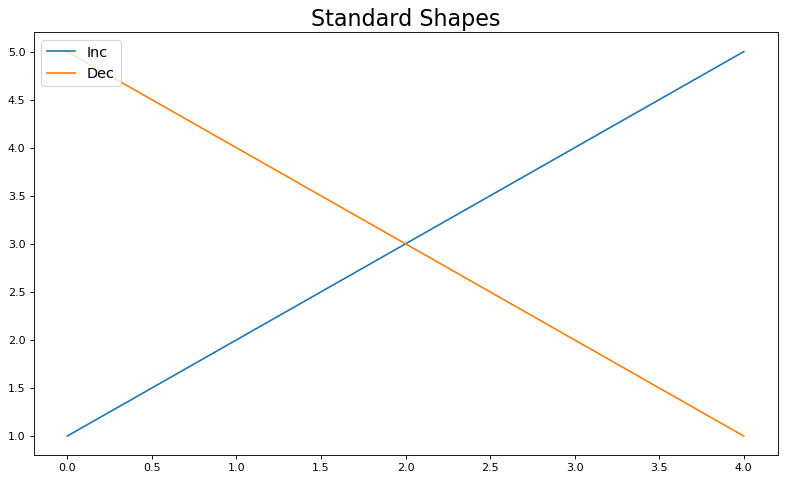

In [546]:
fig, axs = plt.subplots(1,figsize=(12,7 ), dpi=80)

xasis_vector = list(range(len(shapelet_standard_array[0])))

for i in range(len(shapelet_standard_array)):

    axs.plot(xasis_vector,shapelet_standard_array[i],label=shapelet_standard_names[i])

leg1 = axs.legend(loc='upper left',prop={'size': 13})

axs.set_title("Standard Shapes",fontsize=20)

In [547]:
### This file contains incremental day on day cumulative cases across different states
Runtype = "Cases"#### choose Deaths for generating results for deaths and Cases for generating case results

if Runtype =='Cases':
    print("Process will run for Cases")

    Input_path = '../Data_Sources/Cases/'

    Ouput_path = '../Data_Sources/Cases/Output_Files/'

    Actual_incidence_path = Input_path+"/Input_Files/Actual_Incidence_Data/"

    pickle_path = Input_path+"Pickle_Objects/"

    Visualization_path = Input_path+"Visualizations/"
else:
    print("Process will run for Deaths")
    Input_path = '../Data_Sources/Deaths/'

    Ouput_path = '../Data_Sources/Deaths/Output_Files/'

    Actual_incidence_path = Input_path+"/Input_Files/Actual_Incidence_Data/"

    pickle_path = Input_path+"Pickle_Objects/"

    Visualization_path = Input_path+"Visualizations/"


Process will run for Cases


In [548]:
cases_tmp = pd.read_csv(Actual_incidence_path+"US_actual_data.csv")


In [549]:
test_state = "Washington"
US_total = pd.DataFrame(cases_tmp.sum(axis=0))

cases_tmp = pd.concat([cases_tmp,US_total.T])

cases = cases_tmp[cases_tmp['Country']==test_state]

impute = {}

impute['Country'] = {'WashingtonIllinoisCaliforniaArizonaMassachusettsWisconsinTexasNebraskaUtahOregonFloridaNew YorkRhode IslandGeorgiaNew HampshireNorth CarolinaNew JerseyColoradoMarylandNevadaTennesseeHawaiiIndianaKentuckyMinnesotaOklahomaPennsylvaniaSouth CarolinaDistrict of ColumbiaKansasMissouriVermontVirginiaConnecticutIowaLouisianaOhioMichiganSouth DakotaArkansasDelawareMississippiNew MexicoNorth DakotaWyomingAlaskaMaineAlabamaIdahoMontanaPuerto RicoVirgin IslandsGuamWest VirginiaNorthern Mariana IslandsAmerican Samoa':"United States"}

cases = cases.replace(impute)


In [550]:
cases

,id,Country,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,2020-02-20,2020-02-21,2020-02-22,2020-02-23,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28,2020-02-29,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05,2020-04-06,2020-04-07,2020-04-08,2020-04-09,2020-04-10,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20,2020-04-21,2020-04-22,2020-04-23,2020-04-24,2020-04-25,2020-04-26,2020-04-27,2020-04-28,2020-04-29,2020-04-30,2020-05-01,2020-05-02,2020-05-03,2020-05-04,2020-05-05,2020-05-06,2020-05-07,2020-05-08,2020-05-09,2020-05-10,2020-05-11,2020-05-12,2020-05-13,2020-05-14,2020-05-15,2020-05-16,2020-05-17,2020-05-18,2020-05-19,2020-05-20,2020-05-21,2020-05-22,2020-05-23,2020-05-24,2020-05-25,2020-05-26,2020-05-27,2020-05-28,2020-05-29,2020-05-30,2020-05-31,2020-06-01,2020-06-02,2020-06-03,2020-06-04,2020-06-05,2020-06-06,2020-06-07,2020-06-08,2020-06-09,2020-06-10,2020-06-11,2020-06-12,2020-06-13,2020-06-14,2020-06-15,2020-06-16,2020-06-17,2020-06-18,2020-06-19,2020-06-20,2020-06-21,2020-06-22,2020-06-23,2020-06-24,2020-06-25,2020-06-26,2020-06-27,2020-06-28,2020-06-29,2020-06-30,2020-07-01,2020-07-02,2020-07-03,2020-07-04,2020-07-05,2020-07-06,2020-07-07,2020-07-08,2020-07-09,2020-07-10,2020-07-11,2020-07-12,2020-07-13,2020-07-14,2020-07-15,2020-07-16,2020-07-17,2020-07-18,2020-07-19,2020-07-20,2020-07-21,2020-07-22,2020-07-23,2020-07-24,2020-07-25,2020-07-26,2020-07-27,2020-07-28,2020-07-29,2020-07-30,2020-07-31,2020-08-01,2020-08-02,2020-08-03,2020-08-04,2020-08-05,2020-08-06,2020-08-07,2020-08-08,2020-08-09,2020-08-10,2020-08-11,2020-08-12,2020-08-13,2020-08-14,2020-08-15,2020-08-16,2020-08-17,2020-08-18,2020-08-19,2020-08-20,2020-08-21,2020-08-22,2020-08-23,2020-08-24,2020-08-25,2020-08-26,2020-08-27,2020-08-28,2020-08-29,2020-08-30,2020-08-31,2020-09-01,2020-09-02,2020-09-03,2020-09-04,2020-09-05,2020-09-06,2020-09-07,2020-09-08,2020-09-09,2020-09-10,2020-09-11,2020-09-12,2020-09-13,2020-09-14,2020-09-15,2020-09-16,2020-09-17,2020-09-18,2020-09-19,2020-09-20,2020-09-21,2020-09-22,2020-09-23,2020-09-24,2020-09-25,2020-09-26,2020-09-27,2020-09-28,2020-09-29,2020-09-30,2020-10-01,2020-10-02,2020-10-03,2020-10-04,2020-10-05,2020-10-06,2020-10-07,2020-10-08,2020-10-09,2020-10-10,2020-10-11,2020-10-12,2020-10-13,2020-10-14,2020-10-15,2020-10-16,2020-10-17,2020-10-18,2020-10-19,2020-10-20,2020-10-21,2020-10-22,2020-10-23,2020-10-24,2020-10-25,2020-10-26,2020-10-27,2020-10-28,2020-10-29,2020-10-30,2020-10-31,2020-11-01,2020-11-02,2020-11-03,2020-11-04,2020-11-05,2020-11-06,2020-11-07,2020-11-08,2020-11-09,2020-11-10,2020-11-11,2020-11-12,2020-11-13,2020-11-14,2020-11-15,2020-11-16,2020-11-17,2020-11-18,2020-11-19,2020-11-20,2020-11-21,2020-11-22,2020-11-23,2020-11-24,2020-11-25,2020-11-26,2020-11-27,2020-11-28,2020-11-29,2020-11-30,2020-12-01,2020-12-02,2020-12-03,2020-12-04,2020-12-05,2020-12-06,2020-12-07,2020-12-08,2020-12-09,2020-12-10,2020-12-11,2020-12-12,2020-12-13,2020-12-14,2020-12-15,2020-12-16,2020-12-17,2020-12-18,2020-12-19,2020-12-20,2020-12-21,2020-12-22,2020-12-23,2020-12-24,2020-12-25,2020-12-26,2020-12-27,2020-12-28,2020-12-29,2020-12-30,2020-12-31,2021-01-01,2021-01-02,2021-01-03,2021-01-04,2021-01-05,2021-01-06,2021-01-07,2021-01-08,2021-01-09,2021-01-10,2021-01-11,2021-01-12,2021-01-13,2021-01-14,2021-01-15,2021-01-16,2021-01-17,2021-01-18,2021-01-19,2021-01-20,2021-0

In [551]:

N = 157
t = 'Jan 22 2020'
format = '%b %d %Y'
now = datetime.strptime(t,format)
after = now + timedelta(days = N)
print(now)
print(after)

cases_for_use = cases.iloc[:,157:600]
start = 157

days = [i for i in range(start,start+cases_for_use.shape[1])]


2020-01-22 00:00:00
2020-06-27 00:00:00


In [552]:
cases_for_use.columns = days


In [553]:
weekly_cases = pd.DataFrame()
for i in range(start, start+cases_for_use.shape[1],7):
    weekly_cases = pd.concat([weekly_cases,cases_for_use[i]],axis=1)


In [554]:
weekly_cases_2 = weekly_cases.copy()


In [555]:
weekly_cases_2 = weekly_cases.diff(axis=1)

In [556]:
weekly_cases_2[weekly_cases_2<0] = 0


In [557]:

weekly_cases1 = weekly_cases_2[list(weekly_cases_2.columns)[1:]]


weekly_cases1.index = list(cases['Country'].values)

states_list = list(cases['Country'].values)

Actual_covid_tally = weekly_cases1.copy()
# 2020-6-28 is a Sunday

In [558]:
Actual_covid_tally

,164,171,178,185,192,199,206,213,220,227,234,241,248,255,262,269,276,283,290,297,304,311,318,325,332,339,346,353,360,367,374,381,388,395,402,409,416,423,430,437,444,451,458,465,472,479,486,493,500,507,514,521,528,535,542,549,556,563,570,577,584,591,598
Washington,4692,4790,6002,5588,5428,5002,4085,3960,3381,3100,2761,2869,3972,3812,4205,4658,5093,6183,9619,13502,16519,18012,19652,21657,11791,14119,18677,16199,18344,10259,11399,8549,7901,5747,5979,4759,4893,5357,6333,7288,7827,9319,9763,9397,9271,8685,4829,8355,4208,4109,3037,3201,2079,2620,4964,6168,6841,15564,18654,21159,22535,24502,22242


In [559]:
JHU_actual_pd = Actual_covid_tally.copy()

data_array = JHU_actual_pd.values

week_numbers = JHU_actual_pd.columns

In [560]:
pd.set_option('display.max_columns', None)
#JHU_actual_pd

In [561]:
Actual_covid_tally_dict = Actual_covid_tally.T.to_dict()

In [562]:
#### Using a sliding window, compute the runnning averages of fixed window sizes


state_wise_running_averages = []

for state in range(len(states_list)):
    vector = data_array[state]
    running_average = [0]*len(vector)
    
    for k in range(len(vector)):
        #print(k)
        if k==0:
#             print(k)
#             print(vector[k:k+2])
            running_average[k]=round(sum(vector[k:k+2])/2,0)
            
        elif k>0 and k < len(vector)-1:
            running_average[k] = round(sum(vector[k-1:k+2])/3,0)
        elif k==len(vector)-1:
#             print(k)
            running_average[k] = round(sum(vector[k-1:k+1])/2,0)
#             print(vector[k-1:k+1])
    state_wise_running_averages.append(running_average)
    
        
running_average={}
for state in range(len(states_list)):
    
    running_average[states_list[state]] = list(zip(week_numbers,state_wise_running_averages[state]))    


In [563]:
orignial_1 = data_array[0]





In [564]:
def date_formatting(week_nbr):
# week_nbr = 164
    t = 'Jan 22 2020'
    format = '%b %d %Y'
    now = datetime.strptime(t,format)
    after = now + timedelta(days = int(week_nbr))
    return after.date().strftime("%m/%d/%Y")

In [565]:
x = [date_formatting(w) for w in list(Actual_covid_tally.columns)]


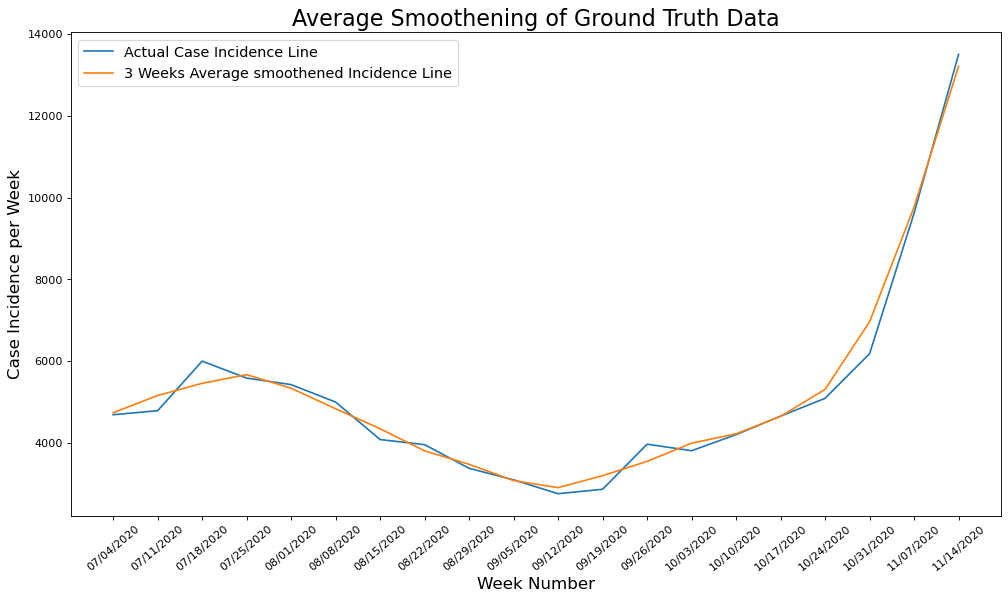

In [566]:
fig, axs = plt.subplots(1,figsize=(15,8 ), dpi=80)
ensemble  = plt.plot(list(Actual_covid_tally.columns)[:20],orignial_1[:20],label="Actual Case Incidence Line")
#     axs[2].legend((usc,ensemble),('Perfis COPEX','Media'), loc = 'best')
ensemble  = plt.plot(list(Actual_covid_tally.columns)[:20],state_wise_running_averages[0][:20],label="3 Weeks Average smoothened Incidence Line")
#     axs[2].legend((usc,ensemble),('Perfis COPEX','Media'), loc = 'best')
leg1 = plt.legend(loc='upper right',prop={'size': 13})

axs.set_xticks(list(Actual_covid_tally.columns)[:20])
axs.set_xticklabels(x[:20],rotation=40,fontsize=10)

plt.title("Average Smoothening of Ground Truth Data", fontsize = 20)

plt.ylabel("Case Incidence per Week",fontsize = 15)

plt.xlabel("Week Number",fontsize = 15)
leg1 = plt.legend(loc='upper left',prop={'size': 13})

plt.show()

## Generating Shapelets for Actual Covid-19 Case/Death Incidence - Ground Truth

In [567]:
### Lets Generate for each week/ state, running vectors of size 5

In [568]:
ShapeLet_Dictionary_State_level = {}

Shapelet_dict_actual_state_week_vector_label = {}

week_actual_vector_dict = {}

for keys in running_average.keys():
#     print(keys)
    State_name = keys
    running_avg = running_average[State_name]



    running_avg_vectors = []
    for i in range(len(running_avg)):
        if i<len(running_avg)-future_weeks:
            if i<=history_weeks:
                vec = running_avg[i-0:i+future_weeks+history_weeks]
            else:
                vec = running_avg[i-history_weeks:i+future_weeks]
            vec1 = [w[1] for w in vec]
            assert len(vec1)==Shapelet_length,"Size of vector not equal to standard shapelet size"


            week_nbr = vec[0][0]
            running_avg_vectors.append((week_nbr,vec1[0],vec1))

    dicy_state = Shapelet_dict_actual_state_week_vector_label.get(State_name,{})
#     print(dicy_state)
#     assert len(vector[2])==Shapelet_length,"Size of vector not equal to standard shapelet size"
    scenarios_list_pearson_perason = [(vector[0],vector[1],return_best_shapelet_pearson(vector[2]),return_all_shapelet_pearson(vector[2])) for vector in running_avg_vectors]
    week_nbr_zip = [(vector[0],vector[2]) for vector in running_avg_vectors]
    week_actual_vector_dict[keys] = week_nbr_zip
#     [print(vector[2]) for vector in running_avg_vectors]
#     print(vector[2])
    for vector in scenarios_list_pearson_perason:
        dicy_state[vector[0]] = [(vector[3],vector[2])]
    Shapelet_dict_actual_state_week_vector_label[State_name] = dicy_state
        

    ShapeLet_Dictionary_State_level[keys] = scenarios_list_pearson_perason

    ## Actual Covid tally plot validation 

    week_nbr_plt = [w[0] for w in scenarios_list_pearson_perason]
    actual_count_plt = [w[1] for w in scenarios_list_pearson_perason]
    labels_plt = [w[2] for w in scenarios_list_pearson_perason]





### Example

In [569]:
Week_sample_vector = [56011.0,
   57945.6,
   62076.3,
   61846.6,
   57295.6]

In [570]:
correlations = return_all_shapelet_pearson(Week_sample_vector)

In [571]:
for i in range(len(correlations)):
    print("Pearson Correlation Between Week Vector and {} : {}".format(shapelet_standard_names[i],correlations[i]))
    

Pearson Correlation Between Week Vector and Inc : 0.37
Pearson Correlation Between Week Vector and Dec : -0.37


In [572]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()



In [573]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Create data
# x=range(1,7)
# y=[-0.193, -0.463, 0.463, -0.645, -0.229, 0.618]
# y2=[-0.283, -0.957, 0.957, -0.964, -0.867, 0.974]
# # Area plot
# plt.fill_between(x, y)
# plt.fill_between(x, y2)

# plt.show()

In [574]:
data = list(ShapeLet_Dictionary_State_level.values())[0]

In [575]:
softmax_vectors = []
week_nbrs = set()
for i in data:
    if i[0] in week_nbrs:
        continue
    softmax_vectors.append(list(softmax(i[3])))
    week_nbrs.add(i[0])
    
    


shapewise_probabilities = []
for j in range(len(softmax_vectors[0])):
    tmp=[]
    for i in range(len(softmax_vectors)):
#         if i==2:
#             continue
        tmp.append(softmax_vectors[i][j])
    
    shapewise_probabilities.append(tmp)



In [576]:
actual_cases_weekwise = {}

for i in data:
    

    actual_cases_weekwise[i[0]]=i[1]
    
top_shapelet_perweek = {}

for i in data:
    
    top_shapelet_perweek[i[0]]=i[2]

In [577]:
x = range(len(shapewise_probabilities[0]))

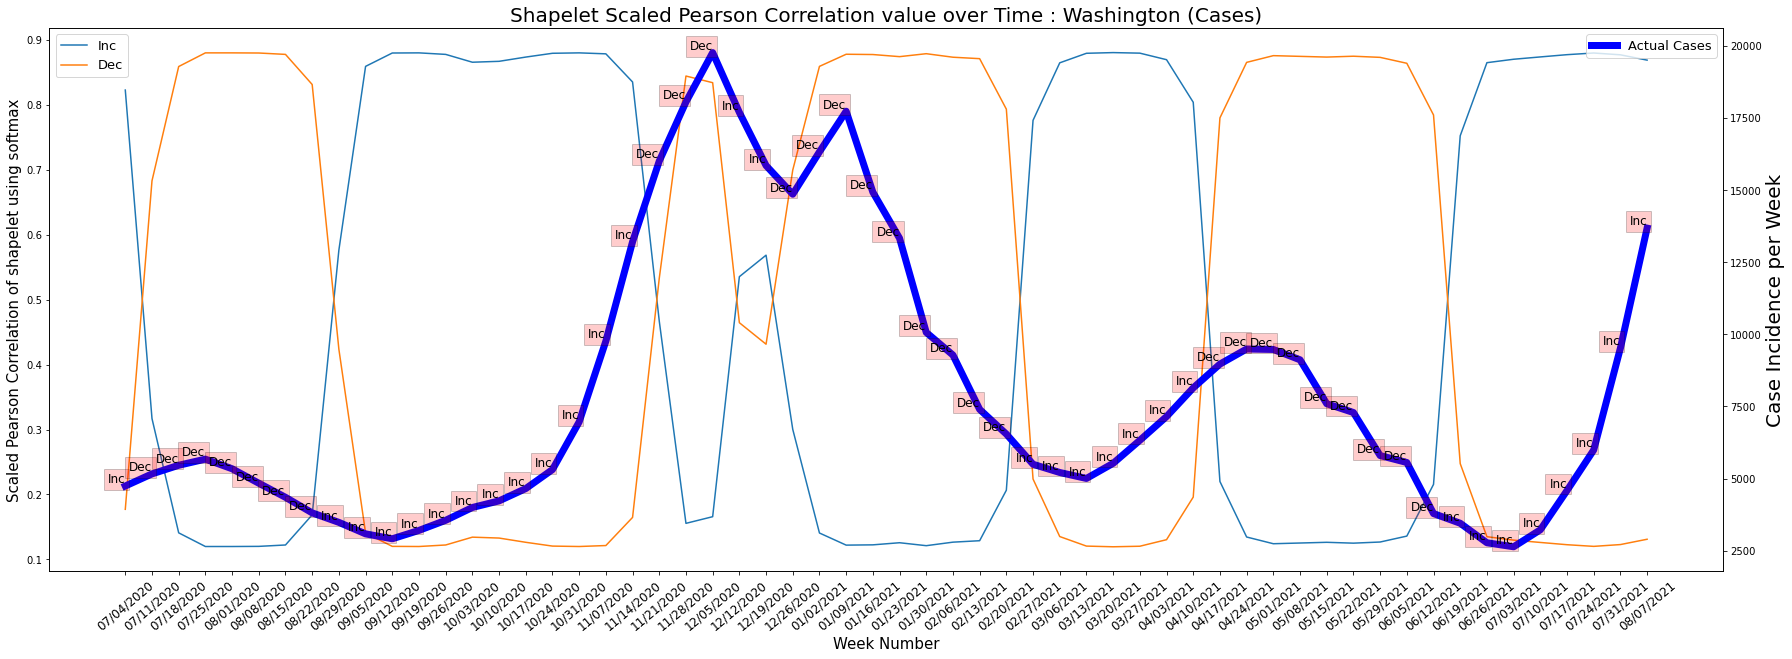

In [578]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats


fig, ax = plt.subplots(figsize=(30, 10))
cnt=0
for i in shapewise_probabilities:
    plt.plot(list(actual_cases_weekwise.keys()), i,label=shapelet_standard_names[cnt])
    cnt+=1

leg1 = ax.legend(loc='upper left',prop={'size': 13})
week_nbr = list(actual_cases_weekwise.keys())

x = [date_formatting(w) for w in week_nbr]


ax.set_xticks(week_nbr)
ax.set_xticklabels(x,rotation=40,fontsize=12)

ax.set_xlabel("Week Number",fontsize = 15)

ax.set_ylabel("Scaled Pearson Correlation of shapelet using softmax",fontsize = 15)

ax2 = ax.twinx()
x1=list(actual_cases_weekwise.keys())
y1 = list(actual_cases_weekwise.values())
ax2.plot(x1,y1,"b",linewidth=7.0,label="Actual Cases")


# ax2.set_xticks(week_nbr)
# ax2.set_xticklabels(x,rotation=40,fontsize=15)

plt.title("Shapelet Scaled Pearson Correlation value over Time : {} (Cases)".format(test_state), fontsize = 20)

ax2.set_ylabel("Case Incidence per Week",fontsize = 20)

lable = list(top_shapelet_perweek.values())
for i in range(len(y1)):

    plt.text(x1[i], y1[i], lable[i],fontsize=12,horizontalalignment='right',
     verticalalignment='bottom',bbox=dict(facecolor='red', alpha=0.2))



ax2.set_xlabel("Week Number",fontsize = 15)

leg2 = ax2.legend(loc='upper right',prop={'size': 13})


#plt.savefig("Shapelet_probablity_overTime {}.png".format(test_state))



In [579]:
pc_vectors = []
for i in data:
    pc_vectors.append(i[3])
    


shapewise_pc = []
for j in range(len(pc_vectors[0])):
    tmp=[]
    for i in range(len(pc_vectors)):
        if i==2:
            continue
        tmp.append(pc_vectors[i][j])
    
    shapewise_pc.append(tmp)



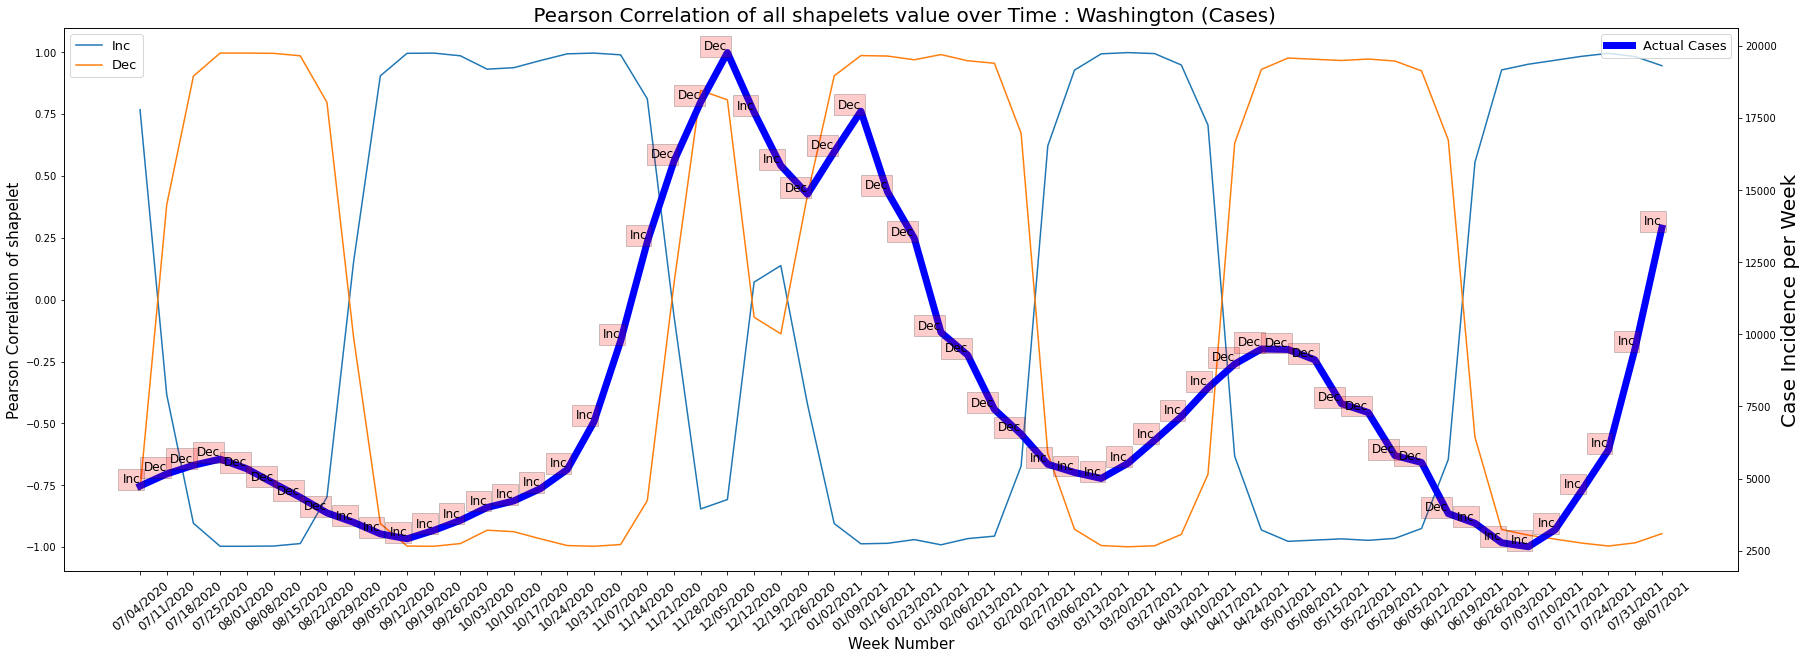

In [580]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats


fig, ax = plt.subplots(figsize=(30, 10))
cnt=0
for i in shapewise_pc:
    plt.plot(list(actual_cases_weekwise.keys()), i,label=shapelet_standard_names[cnt])
    cnt+=1

leg1 = ax.legend(loc='upper left',prop={'size': 13})
week_nbr = list(actual_cases_weekwise.keys())

x = [date_formatting(w) for w in week_nbr]


ax.set_xticks(week_nbr)
ax.set_xticklabels(x,rotation=40,fontsize=12)

ax.set_xlabel("Week Number",fontsize = 15)

ax.set_ylabel("Pearson Correlation of shapelet",fontsize = 15)

ax2 = ax.twinx()
x1=list(actual_cases_weekwise.keys())
y1 = list(actual_cases_weekwise.values())
ax2.plot(x1,y1,"b",linewidth=7.0,label="Actual Cases")


# ax2.set_xticks(week_nbr)
# ax2.set_xticklabels(x,rotation=40,fontsize=15)

plt.title(" Pearson Correlation of all shapelets value over Time : {} (Cases)".format(test_state), fontsize = 20)

ax2.set_ylabel("Case Incidence per Week",fontsize = 20)

lable = list(top_shapelet_perweek.values())
for i in range(len(y1)):

    plt.text(x1[i], y1[i], lable[i],fontsize=12,horizontalalignment='right',
     verticalalignment='bottom',bbox=dict(facecolor='red', alpha=0.2))



ax2.set_xlabel("Week Number",fontsize = 15)

leg2 = ax2.legend(loc='upper right',prop={'size': 13})


#plt.savefig("Shapelet_PC_values_overTime {}.png".format(test_state))



In [581]:

shapelet_Combinatinos = list(combinations(shapelet_standard_array,2))

shapelet_Combinatinos_names = list(combinations(shapelet_standard_names,2))



pairwise_similairty = {}
for i in range(len(shapelet_Combinatinos_names)):
    vector1 = shapelet_Combinatinos[i][0]
    vector2 = shapelet_Combinatinos[i][1]
    pairwise_similairty[shapelet_Combinatinos_names[i]]  = 1-spatial.distance.cosine(vector1,vector2)
    
    

overall_sum = sum(pairwise_similairty.values())
for k,v in pairwise_similairty.items():
    pairwise_similairty[k] = round(v/overall_sum,2)
    

In [582]:
pairwise_similairty

{('Inc', 'Dec'): 1.0}

In [503]:
# endtime = time.time()

# print("Time Taken by Notebook {}".format(((endtime-start)/60)))